# Midiendo rendimiento y riesgo con datos históricos

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/7/7d/Copper_Price_History_USD.png" width="600px" height="400px" />

> Ya sabemos que podemos caracterizar la distribución de rendimientos de un activo mediante una medida de tendencia central (media: rendimiento esperado) y una medida de dispersión (desviación estándar: volatilidad). 

> En la clase pasada vimos como obtener reportes históricos de precios de activos. ¿Cómo usamos estos históricos para medir el rendimiento esperado y la volatilidad de los rendimientos?

*Objetivos:*
- Calcular los rendimientos a partir de históricos de precios.
- Estimar rendimiento esperado y riesgo a partir de históricos de rendimientos.
- Anualizar rendimiento y volatilidad cuando los datos están en una base de tiempo menor.
- Verificar la relación entre rendimiento y riesgo a través de datos reales.

**Referencias:**
- http://pandas.pydata.org/
- https://pandas-datareader.readthedocs.io/en/latest/
- Notas del curso "Portfolio Selection and Risk Management", Rice University, disponible en Coursera.
___

## 1. Cálculo de los rendimientos

Muy bien, ya entonces sabemos descargar históricos de precios...

**Ejemplo:** trabajaremos esta clase con activos que se encuentran en el top-10 del índice S&P500. Descargar precios ajustados en el cierre de Microsoft (MSFT), Apple (AAPL), Amazon (AMZN), Facebook (FB) y Alphabet Inc. (GOOGL) desde el primero de enero del 2015 hasta hoy.

In [31]:
# Importar paquetes
import pandas as pd
import numpy as np
import pandas_datareader.data as web
%matplotlib inline


In [32]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [33]:
# Información
names=['MSFT','AAPL','AMZN','FB','GOOGL','^GSPC']
start_date='2015-01-01'

In [34]:
# Precios diarios
closes=get_adj_closes(tickers=names,
                     start_date=start_date
                     )
closes.sample(10)

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2017-01-06,59.541157,112.368469,795.989990,123.410004,825.210022,2276.979980
2019-10-09,137.771210,225.814514,1721.989990,179.850006,1202.400024,2919.399902
2019-05-17,127.212082,187.276581,1869.000000,185.300003,1168.780029,2859.530029
2019-11-25,151.229996,265.739319,1773.839966,199.789993,1305.640015,3133.639893
2020-01-23,166.720001,318.474182,1884.579956,219.759995,1484.689941,3325.540039
2015-11-02,48.769142,112.489754,628.349976,103.309998,747.739990,2104.050049
2016-08-01,52.920212,100.007835,767.739990,124.309998,800.940002,2170.840088
2017-12-06,80.185715,163.656967,1152.349976,176.059998,1032.719971,2629.270020
2019-12-03,149.309998,258.835724,1769.959961,198.820007,1294.739990,3093.199951


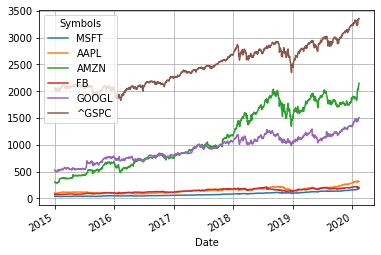

In [35]:
# Gráfico de histórico de precios diarios
closes.plot(figsize=(6,4),grid=True)

### 1.1. Rendimientos porcentuales

Muy bien, pero para el análisis no trabajamos con los precios sino con los rendimientos... **¿porqué?**

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual
$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}
$$
para $t=1,\ldots,n$.

*¡Cuidado!* los rendimientos son de acuerdo a la base de tiempo en que se reportan los precios. Por ejemplo: 
- si los precios se reportan en una base diaria, los rendimientos también son diarios;
- si los precios se reportan en una base mensual, los rendimientos también son mensuales.

In [36]:
# Método shift() de un DataFrame...
closes.shift()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,41.979183,100.216454,308.519989,78.449997,529.549988,2058.199951
2015-01-06,41.593143,97.393181,302.190002,77.190002,519.460022,2020.579956
2015-01-07,40.982681,97.402374,295.290009,76.150002,506.640015,2002.609985
2015-01-08,41.503380,98.768150,298.420013,76.150002,505.149994,2025.900024
...,...,...,...,...,...,...
2020-02-05,180.119995,318.095062,2049.669922,209.830002,1445.410034,3297.590088
2020-02-06,179.899994,320.688934,2039.869995,210.110001,1446.050049,3334.689941
2020-02-07,183.630005,324.440002,2050.229980,210.850006,1475.969971,3345.780029


In [37]:
# Calcular los rendimientos
ret=((closes-closes.shift())/closes.shift()).dropna()
ret.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,-0.009196,-0.028172,-0.020517,-0.016061,-0.019054,-0.018278
2015-01-06,-0.014677,0.000094,-0.022833,-0.013473,-0.024679,-0.008893
2015-01-07,0.012705,0.014022,0.010600,0.000000,-0.002941,0.011630
2015-01-08,0.029418,0.038423,0.006836,0.026658,0.003484,0.017888
2015-01-09,-0.008405,0.001072,-0.011749,-0.005628,-0.012211,-0.008404


In [38]:
# Otra forma (más fácil)
ret=closes.pct_change().dropna()
ret

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,-0.009196,-0.028172,-0.020517,-0.016061,-0.019054,-0.018278
2015-01-06,-0.014677,0.000094,-0.022833,-0.013473,-0.024679,-0.008893
2015-01-07,0.012705,0.014022,0.010600,0.000000,-0.002941,0.011630
2015-01-08,0.029418,0.038423,0.006836,0.026658,0.003484,0.017888
2015-01-09,-0.008405,0.001072,-0.011749,-0.005628,-0.012211,-0.008404
...,...,...,...,...,...,...
2020-02-05,-0.001221,0.008154,-0.004781,0.001334,0.000443,0.011251
2020-02-06,0.020734,0.011697,0.005079,0.003522,0.020691,0.003326
2020-02-07,0.001416,-0.013593,0.014169,0.007019,0.002127,-0.005401


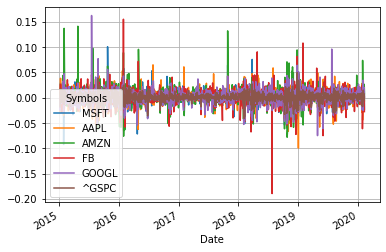

In [39]:
# Graficar...
ret.plot(figsize=(6,4),grid=True)

**¿Qué se observa respecto a los precios?**

Respuestas:
- Los rendimientos parecen conservar tendecias estadísticas constantes (por ejemplo, oscilan al rededor de números cercanos a cero). 

### 1.2. Rendimientos logarítmicos (log-rendimientos)

Otro rendimiento usado con frecuencia es el rendimiento continuamente compuesto o rendimiento logaritmico. Éste, está definido como

$$
r_t=\ln\left(\frac{S_t}{S_{t-1}}\right).
$$

Es fácil darse cuenta que $r_t=\ln(1+R_t)$.

<font color=blue>Ver en el tablero</font> que si $0\leq|x|\ll 1$, entonces $\ln(1+x)\approx x$.

In [40]:
# Calcular rendimientos continuamente compuestos
log_ret=np.log(closes / closes.shift()).dropna()
log_ret.head(2).dropna()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,-0.009239,-0.028576,-0.020731,-0.016191,-0.019238,-0.018447
2015-01-06,-0.014786,0.000094,-0.023098,-0.013565,-0.024989,-0.008933


In [41]:
# Recordar rendimientos porcentuales. Ver que son similares
ret.head(2)

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,-0.009196,-0.028172,-0.020517,-0.016061,-0.019054,-0.018278
2015-01-06,-0.014677,0.000094,-0.022833,-0.013473,-0.024679,-0.008893


In [42]:
# Veamos el valor absoluto de la diferencia
np.abs(ret -log_ret).head(3)

Symbols,MSFT,AAPL,AMZN,FB,GOOGL,^GSPC
Date,,,,,,
2015-01-05,0.000043,4.044376e-04,0.000213,0.000130,0.000184,0.000169
2015-01-06,0.000109,4.454919e-09,0.000265,0.000092,0.000310,0.000040
2015-01-07,0.000080,9.739881e-05,0.000056,0.000000,0.000004,0.000067


Por lo anterior, muchas veces se usan para el análisis los rendimientos continuamente compuestos.
___

## 2. Caracterización de la distribución de los rendimientos

Entonces:
- partimos de que tenemos los rendimientos porcentuales diarios de Apple, Walmart, IBM y Nike desde inicios del 2011 a finales del 2015;
- ¿cómo resumirían estos datos?

In [43]:
# Rendimiento medio diario (media aritmética)
mean_ret=ret.mean()
mean_ret

Symbols
MSFT     0.001260
AAPL     0.001026
AMZN     0.001680
FB       0.000915
GOOGL    0.000927
^GSPC    0.000417
dtype: float64

In [44]:
# Volatilidad diaria (desviación estándar)
vol=ret.std()
vol

Symbols
MSFT     0.014703
AAPL     0.015672
AMZN     0.018416
FB       0.017795
GOOGL    0.014960
^GSPC    0.008447
dtype: float64

In [45]:
# Podemos resumir en un DataFrame
ret_summary=pd.DataFrame({'Mean': mean_ret, 'Vol': vol})
ret_summary

,Mean,Vol
Symbols,,
MSFT,0.001260,0.014703
AAPL,0.001026,0.015672
AMZN,0.001680,0.018416
FB,0.000915,0.017795
GOOGL,0.000927,0.014960
^GSPC,0.000417,0.008447


Normalmente se reportan rendimientos esperados y volatilidades en una base anual. Para anualizar:

$$E[r_a]=12E[r_m]=252E[r_d]=52E[r_w],\text{ y}$$

$$\sigma_{r_a}=\sqrt{12}\sigma_{r_m}=\sqrt{252}\sigma_{r_d}=\sqrt{52}\sigma_{r_w}$$

In [46]:
# Resumen en base anual
annual_ret_summary = pd.DataFrame({'Mean' : mean_ret * 252,
                                  'Vol' : vol * np.sqrt(252)
                                  })
annual_ret_summary

,Mean,Vol
Symbols,,
MSFT,0.317572,0.233398
AAPL,0.258540,0.248788
AMZN,0.423260,0.292342
FB,0.230704,0.282487
GOOGL,0.233518,0.237489
^GSPC,0.105006,0.134087


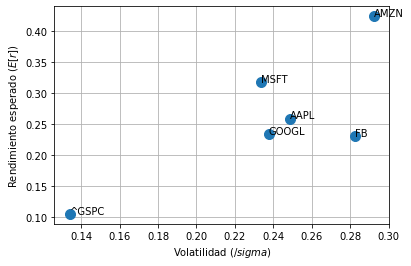

In [55]:
# Gráfico rendimiento esperado vs. volatilidad
import matplotlib.pyplot as plt
# Puntos a graficar
x_points = annual_ret_summary.loc[:,'Vol']
y_points = annual_ret_summary.loc[:,'Mean']
# Ventana para graficar
plt.figure(figsize=(6,4))
# Graficar puntos
plt.plot(x_points, y_points, 'o', ms=10)
plt.grid()
# Etiquetas de los ejes
plt.xlabel('Volatilidad ($/sigma$)')
plt.ylabel('Rendimiento esperado ($E[r$])')
# Etiqueta de cada instrumento
plt.text(x_points[0], y_points[0],annual_ret_summary.index[0])
plt.text(x_points[1], y_points[1],annual_ret_summary.index[1])
plt.text(x_points[2], y_points[2],annual_ret_summary.index[2])
plt.text(x_points[3], y_points[3],annual_ret_summary.index[3])
plt.text(x_points[4], y_points[4],annual_ret_summary.index[4])
plt.text(x_points[5], y_points[5],annual_ret_summary.index[5])
plt.show()

### 2.1 Ajuste de curvas con mínimos cuadrados
Consideramos que tenemos un conjunto de n pares ordenados de datos $(\sigma_{r_i},E[r_i])$, para $i=1,2,3,\dots,n$... **en este caso corresponden a volatilidad y rendimiento esperado**

#### ¿Cuál es la recta que mejor se ajusta a estos datos?
Consideramos entonces ajustes de la forma $\hat{f}(\sigma) = \beta_0+\beta_1 \sigma = \left[1 \quad \sigma\right]\left[\begin{array}{c} \beta_0 \\ \beta_1 \end{array}\right]=\left[1 \quad \sigma\right]\boldsymbol{\beta}$ (lineas rectas).

Para decir '*mejor*', tenemos que definir algún sentido en que una recta se ajuste *mejor* que otra.

**Mínimos cuadrados**: el objetivo es seleccionar los coeficientes $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$, de forma que la función evaluada en los puntos $\sigma_{r_i}$ ($\hat{f}(\sigma_{r_i})$) aproxime los valores correspondientes $E[r_i]$.

La formulación por mínimos cuadrados, encuentra los $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$ que minimiza
$$\sum_{i=1}^{n}(E[r_i]-\hat{f}(\sigma_{r_i}))^2$$

In [57]:
# Importar el módulo optimize de la librería scipy
from scipy.optimize import minimize

In [58]:
# Funcion minimize
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

In [61]:
# Funcion objetivo y condicion inicial
def objetivo(beta, vol, mean_ret):
    recta = beta[0] + beta[1]*vol
    return ((mean_ret - recta)**2).sum()



In [63]:
# Resolver problema de optimizacion
beta_ini = [0, 0]
solucion = minimize(fun= objetivo,
                    x0=beta_ini, 
                    args =(annual_ret_summary['Vol'],
                           annual_ret_summary['Mean']))
solucion

      fun: 0.021014126611568
 hess_inv: array([[ 1.86966742, -7.50249636],
       [-7.50249636, 31.51003624]])
      jac: array([-1.62981451e-09, -1.62981451e-09])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([-0.08978334,  1.47508912])

In [64]:
beta_opt = solucion.x

In [65]:
# Ordenar datos con np.sort
beta_opt

array([-0.08978334,  1.47508912])

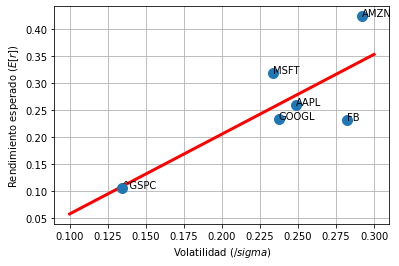

In [69]:
# Gráfico rendimiento esperado vs. volatilidad, y ajuste
# Puntos a graficar
x_points = annual_ret_summary.loc[:,'Vol']
y_points = annual_ret_summary.loc[:,'Mean']
# Ventana para graficar
plt.figure(figsize=(6,4))
# Grafica de recta ajustada
x_recta = np.linspace(0.1,0.3,100)
y_recta = beta_opt[1]*x_recta + beta_opt[0]
plt.plot(x_recta,y_recta,'r', lw=3, label='Recta Ajustada')
# Graficar puntos
plt.plot(x_points, y_points, 'o', ms=10)
plt.grid()
# Etiquetas de los ejes
plt.xlabel('Volatilidad ($/sigma$)')
plt.ylabel('Rendimiento esperado ($E[r$])')
# Etiqueta de cada instrumento
plt.text(x_points[0], y_points[0],annual_ret_summary.index[0])
plt.text(x_points[1], y_points[1],annual_ret_summary.index[1])
plt.text(x_points[2], y_points[2],annual_ret_summary.index[2])
plt.text(x_points[3], y_points[3],annual_ret_summary.index[3])
plt.text(x_points[4], y_points[4],annual_ret_summary.index[4])
plt.text(x_points[5], y_points[5],annual_ret_summary.index[5])
plt.show()

**¿Qué se puede concluir acerca de la relación entre riesgo (medido con la volatilidad) y el rendimiento esperado (medido con la media)?**

Respuestas:
- Para un rendimiento esperado más alto, se necesita asumir más riesgo.
- La relación entre rendimiento esperado y riesgo es positiva (de acuerdo a los datos).

## 3. Comentarios finales acerca del uso de datos históricos.

### ¡Cuidado!
- Es cierto que los patrones que vemos sobre periodos largos de tiempo en diferentes tipos de intrumentos son muy robustos en términos de la relación rendimiento/riesgo (positiva).
- Por tanto, esperamos rendimientos más altos en el futuro cuando asumimos cierto riesgo.
- ¿Cómo encontramos ese 'rendimiento esperado' en el futuro'? Datos históricos (humanos: tendencia a generalizar)

- Entonces, la idea es que si los rendimientos esperados son un p.e. estacionario, el promedio de muchos rendimientos pasados es una buena estimación del rendimiento esperado futuro (Teorema del límite central).
- ¿Deberíamos pensarlo dos veces?

## SI

Problemas:
- La muestra de datos en el periodo específico de tiempo puede estar sesgada.
- Ventanas de tiempo más grandes reducen especificidad de la muestra y estimados más precisos.
 - Aún así, datos muy viejos pueden ser no representativos.
- Nuevos fondos o estrategias de inversión están a menudo sesgados positivamente:
 - reporte de resultados en tiempos voluntarios;
 - las que mueren (no funcionan), no se reportan;

# Anuncios parroquiales:
## 1. Fin Módulo 1. Revisar que se hayan cumplido los objetivos del módulo (Clase0)
## 2. Tarea: revisar archivo "Tarea3_MidiendoRendimientoRiesgo" en clase. Para el viernes 14 de Febrero.
## 3. Recordar quiz la siguiente clase.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>